# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

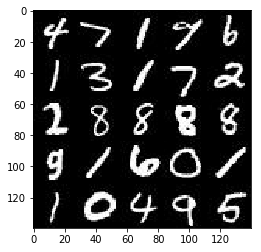

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

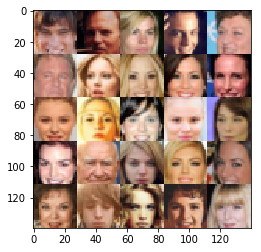

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    fake_inputs = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)
    return real_inputs, fake_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # 14x14x64 (because of strides / 2)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*256)
        nn = tf.layers.batch_normalization(x, training=is_train)
        
        # Reshape before passing to conv layer
        nn = tf.reshape(nn, (-1, 7, 7, 256))
        # Leaky relu
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 7, 7, 256)
        
        nn = tf.layers.conv2d_transpose(nn, 128, (5, 5), strides=1, padding='same')
        nn = tf.layers.batch_normalization(nn, training=is_train)
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 7, 7, 128) # because of stride 1
        
        nn = tf.layers.conv2d_transpose(nn, 64, (5, 5), strides=2, padding='same')
        nn = tf.layers.batch_normalization(nn, training=is_train)
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 14, 14, 64)
    
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(nn, out_channel_dim, (5, 5), strides=2, padding='same')
        out = tf.tanh(logits)
            
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create the model inputs
    real_inputs, fake_inputs, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Get the loss for the discriminator and generator
    d_loss, g_loss = model_loss(real_inputs, fake_inputs, data_shape[3])
    
    # Get optimization operations
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    losses = []
    n_img_show = 15
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={real_inputs: batch_images, 
                                                 fake_inputs: batch_z, 
                                                 lr_tensor: learning_rate})
                
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, 
                                                 fake_inputs: batch_z, 
                                                 lr_tensor: learning_rate})
                
                if step % 15 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, fake_inputs: batch_z})
                    train_loss_g = g_loss.eval({fake_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % 100 == 0:
                    show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        print("Final train discriminator Loss: {:.4f}\nFinal train generator Loss: {:.4f}".format(losses[-1][0], losses[-1][1]))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3846... Generator Loss: 0.0385


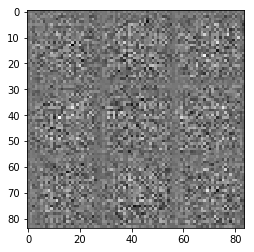

Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.4275
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 4.0214
Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 0.6319
Epoch 1/2... Discriminator Loss: 0.4823... Generator Loss: 1.8001


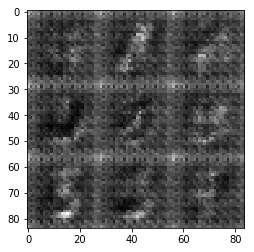

Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 3.3511
Epoch 1/2... Discriminator Loss: 0.4092... Generator Loss: 2.3795
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 2.0450
Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 2.3614
Epoch 1/2... Discriminator Loss: 0.3231... Generator Loss: 3.2953
Epoch 1/2... Discriminator Loss: 0.2360... Generator Loss: 1.9925
Epoch 1/2... Discriminator Loss: 0.2568... Generator Loss: 2.0606


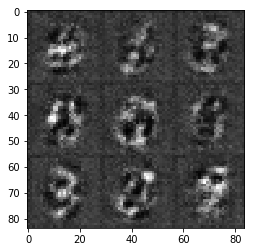

Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.2675
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 8.0522
Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 4.7866
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 1.3854
Epoch 1/2... Discriminator Loss: 0.2145... Generator Loss: 2.4443
Epoch 1/2... Discriminator Loss: 0.1769... Generator Loss: 2.7663
Epoch 1/2... Discriminator Loss: 0.1693... Generator Loss: 2.3831


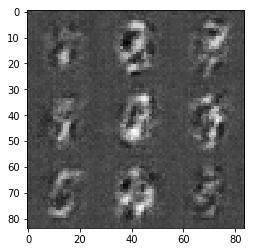

Epoch 1/2... Discriminator Loss: 0.1835... Generator Loss: 3.0781
Epoch 1/2... Discriminator Loss: 0.1955... Generator Loss: 2.4336
Epoch 1/2... Discriminator Loss: 1.6129... Generator Loss: 6.0588
Epoch 1/2... Discriminator Loss: 0.3204... Generator Loss: 1.9030
Epoch 1/2... Discriminator Loss: 0.2602... Generator Loss: 2.1014
Epoch 1/2... Discriminator Loss: 0.3053... Generator Loss: 1.7234


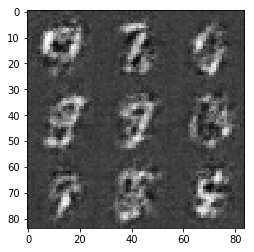

Epoch 1/2... Discriminator Loss: 0.1467... Generator Loss: 2.7754
Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 2.6938
Epoch 1/2... Discriminator Loss: 0.1684... Generator Loss: 2.3529
Epoch 1/2... Discriminator Loss: 0.1936... Generator Loss: 2.1809
Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 2.2220
Epoch 2/2... Discriminator Loss: 0.1373... Generator Loss: 2.5324


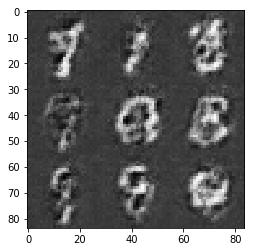

Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 2.3685
Epoch 2/2... Discriminator Loss: 0.2423... Generator Loss: 2.1828
Epoch 2/2... Discriminator Loss: 0.2602... Generator Loss: 1.9240
Epoch 2/2... Discriminator Loss: 0.2198... Generator Loss: 2.1571
Epoch 2/2... Discriminator Loss: 0.1767... Generator Loss: 2.4994
Epoch 2/2... Discriminator Loss: 0.1610... Generator Loss: 2.3546


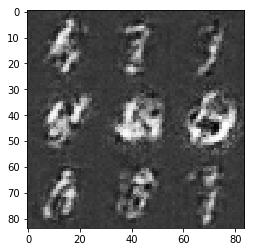

Epoch 2/2... Discriminator Loss: 0.1756... Generator Loss: 2.2768
Epoch 2/2... Discriminator Loss: 0.1413... Generator Loss: 2.5706
Epoch 2/2... Discriminator Loss: 0.1468... Generator Loss: 2.5617
Epoch 2/2... Discriminator Loss: 0.1497... Generator Loss: 2.5436
Epoch 2/2... Discriminator Loss: 0.1336... Generator Loss: 2.5924
Epoch 2/2... Discriminator Loss: 0.1372... Generator Loss: 2.5403
Epoch 2/2... Discriminator Loss: 0.1230... Generator Loss: 2.5839


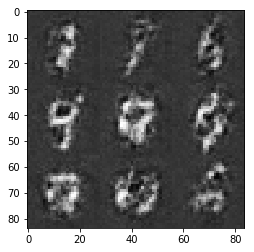

Epoch 2/2... Discriminator Loss: 0.1071... Generator Loss: 2.7782
Epoch 2/2... Discriminator Loss: 0.1235... Generator Loss: 2.7109
Epoch 2/2... Discriminator Loss: 0.0887... Generator Loss: 2.9226
Epoch 2/2... Discriminator Loss: 0.1303... Generator Loss: 2.4729
Epoch 2/2... Discriminator Loss: 0.0840... Generator Loss: 3.1310
Epoch 2/2... Discriminator Loss: 0.1065... Generator Loss: 3.0383
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 1.7897


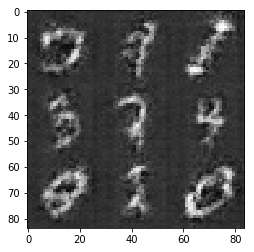

Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.2708
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.7429
Epoch 2/2... Discriminator Loss: 0.4090... Generator Loss: 1.3920
Epoch 2/2... Discriminator Loss: 0.2712... Generator Loss: 1.9951
Epoch 2/2... Discriminator Loss: 0.2088... Generator Loss: 2.1691
Epoch 2/2... Discriminator Loss: 0.2801... Generator Loss: 1.6617


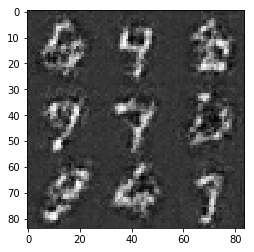

Epoch 2/2... Discriminator Loss: 0.1362... Generator Loss: 2.6040
Epoch 2/2... Discriminator Loss: 0.1750... Generator Loss: 2.1587
Epoch 2/2... Discriminator Loss: 0.2044... Generator Loss: 2.0552
Epoch 2/2... Discriminator Loss: 0.0885... Generator Loss: 3.0835
Epoch 2/2... Discriminator Loss: 0.0971... Generator Loss: 2.8927


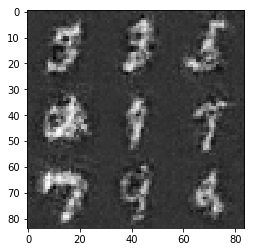

Final train discriminator Loss: 0.0971
Final train generator Loss: 2.8927...


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2894... Generator Loss: 0.1371


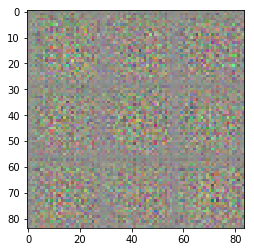

Epoch 1/1... Discriminator Loss: 0.2647... Generator Loss: 1.9210
Epoch 1/1... Discriminator Loss: 0.1527... Generator Loss: 3.3892
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 5.9191
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 1.5099
Epoch 1/1... Discriminator Loss: 0.3222... Generator Loss: 1.7460


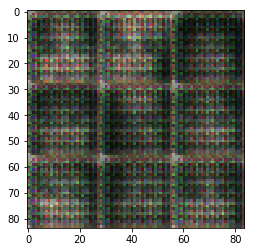

Epoch 1/1... Discriminator Loss: 0.1341... Generator Loss: 2.7583
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 5.0286
Epoch 1/1... Discriminator Loss: 0.2656... Generator Loss: 9.7937
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 3.3851
Epoch 1/1... Discriminator Loss: 4.9081... Generator Loss: 0.0246
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 2.2162
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 5.3113


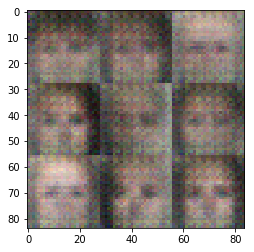

Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 2.3040
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 1.7594
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.5640


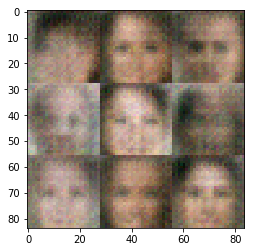

Epoch 1/1... Discriminator Loss: 0.2606... Generator Loss: 2.1643
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 3.2146
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 4.1518
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 3.5106
Epoch 1/1... Discriminator Loss: 0.1926... Generator Loss: 3.7456


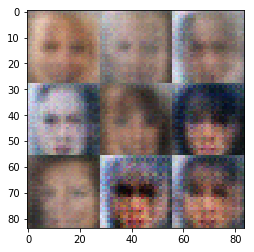

Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 0.2487... Generator Loss: 2.8976
Epoch 1/1... Discriminator Loss: 0.2766... Generator Loss: 5.6863
Epoch 1/1... Discriminator Loss: 0.2503... Generator Loss: 2.7476
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 8.1421
Epoch 1/1... Discriminator Loss: 0.1224... Generator Loss: 7.0610
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 8.7826


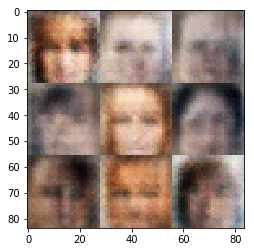

Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 7.2256
Epoch 1/1... Discriminator Loss: 0.2425... Generator Loss: 1.9733
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 3.9991
Epoch 1/1... Discriminator Loss: 0.0786... Generator Loss: 4.2630
Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 4.8154
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 5.3528
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 8.3340


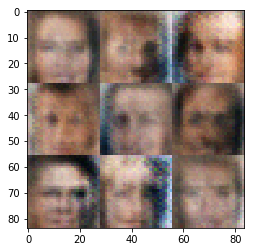

Epoch 1/1... Discriminator Loss: 0.1164... Generator Loss: 6.1485
Epoch 1/1... Discriminator Loss: 0.0878... Generator Loss: 4.9822
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 0.2337... Generator Loss: 1.8216
Epoch 1/1... Discriminator Loss: 0.0770... Generator Loss: 7.6993
Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 1.7031


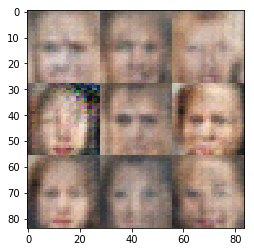

Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 7.1712
Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 2.1299
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 8.0430
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 2.8394
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 8.9966
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 6.6220
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.4141


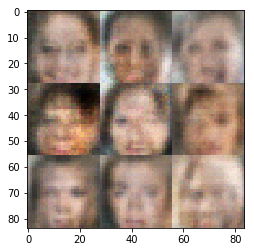

Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 6.6188
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 3.9927
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 8.1228
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 9.3305
Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 4.4256
Epoch 1/1... Discriminator Loss: 0.0374... Generator Loss: 7.1501
Epoch 1/1... Discriminator Loss: 0.3047... Generator Loss: 1.6323


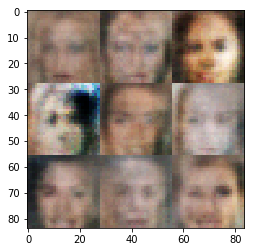

Epoch 1/1... Discriminator Loss: 0.2791... Generator Loss: 10.3532
Epoch 1/1... Discriminator Loss: 0.0269... Generator Loss: 11.6979
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 6.6371
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 5.7301
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 6.8387
Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 6.2657


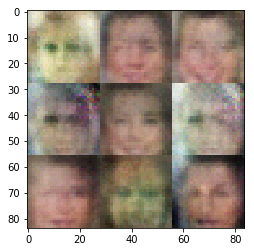

Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 7.2313
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 6.9150
Epoch 1/1... Discriminator Loss: 0.0204... Generator Loss: 6.4349
Epoch 1/1... Discriminator Loss: 0.2713... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 7.9575
Epoch 1/1... Discriminator Loss: 0.0963... Generator Loss: 2.6806
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 6.4500


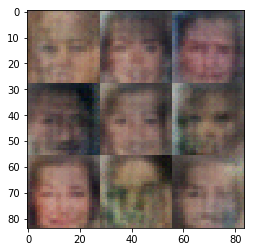

Epoch 1/1... Discriminator Loss: 0.0305... Generator Loss: 4.3089
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 4.3067
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 1.8228
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 7.0850
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 3.9182


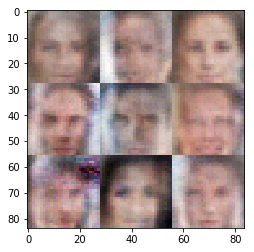

Epoch 1/1... Discriminator Loss: 0.3125... Generator Loss: 5.7123
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 9.7624
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 8.8996
Epoch 1/1... Discriminator Loss: 0.0534... Generator Loss: 3.5598
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 7.2999
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 6.9925


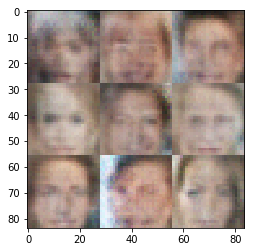

Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 10.4775
Epoch 1/1... Discriminator Loss: 0.1247... Generator Loss: 3.4025
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 6.0076
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 13.7471
Epoch 1/1... Discriminator Loss: 0.2890... Generator Loss: 1.6827
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 6.5280
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 7.3788


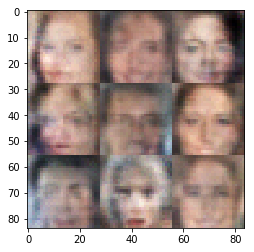

Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 1.7091
Epoch 1/1... Discriminator Loss: 0.1658... Generator Loss: 2.8994
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 9.0796
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 5.0029
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 6.4285
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 7.5310
Epoch 1/1... Discriminator Loss: 0.0238... Generator Loss: 6.2819


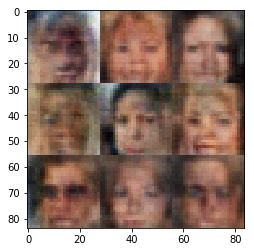

Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 6.8715
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 9.0492
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 10.1910
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 3.9769
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 7.8769


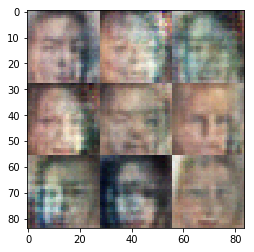

Final train discriminator Loss: 0.0075
Final train generator Loss: 7.8769...


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.